# Module 3:To GenAI or Not

### Persona: I'm a threat hunter who is eager to adopt new technology. I want to see if I can analyze suspicious activities with LLMs

### Scenario: I want to hunt and validate a few hypotheses based on seeing the latest threat feeds

# 1. Setup

In [2]:
# Check if running in Colab
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

In [3]:
# Install requirements for Colab
if is_colab():
    %pip install -r "https://raw.githubusercontent.com/AI-and-Security/old-soc-new-tricks/main/requirements-colab.txt"

In [4]:
# Set up data directory based on environment
if is_colab():
    # Create data directory in Colab
    import os
    DATA_DIR = "./data"
    os.makedirs(DATA_DIR, exist_ok=True)
    
    # Download data files from GitHub repository
    !git clone https://github.com/AI-and-Security/old-soc-new-tricks.git temp_repo
    !mkdir -p {DATA_DIR}
    !cp -r temp_repo/data/* {DATA_DIR}/
    !rm -rf temp_repo
    print("✅ Data files downloaded to Colab environment")
else:
    # Local environment - use relative path
    DATA_DIR = "../data"

print(f"📂 Using data directory: {DATA_DIR}")

📂 Using data directory: ../data


In [5]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')



In [6]:
# For LLM comparison (if OpenAI key is available)
try:
    from openai import OpenAI
    import os
    from dotenv import load_dotenv
    load_dotenv()
    
    client = OpenAI(base_url="https://openrouter.ai/api/v1", api_key=os.getenv('OPENROUTER_API_KEY'))
    LLM_AVAILABLE = True
    print("✅ OpenRouter client initialized")
except Exception as e:
    LLM_AVAILABLE = False
    print("⚠️ OpenRouter not available. Will show conceptual examples only.")
    print(f"Error: {e}")

print("📊 Libraries loaded successfully!")

✅ OpenRouter client initialized
📊 Libraries loaded successfully!


In [7]:
security_data = pd.read_csv(f"{DATA_DIR}/security_interesting_events_data.csv")

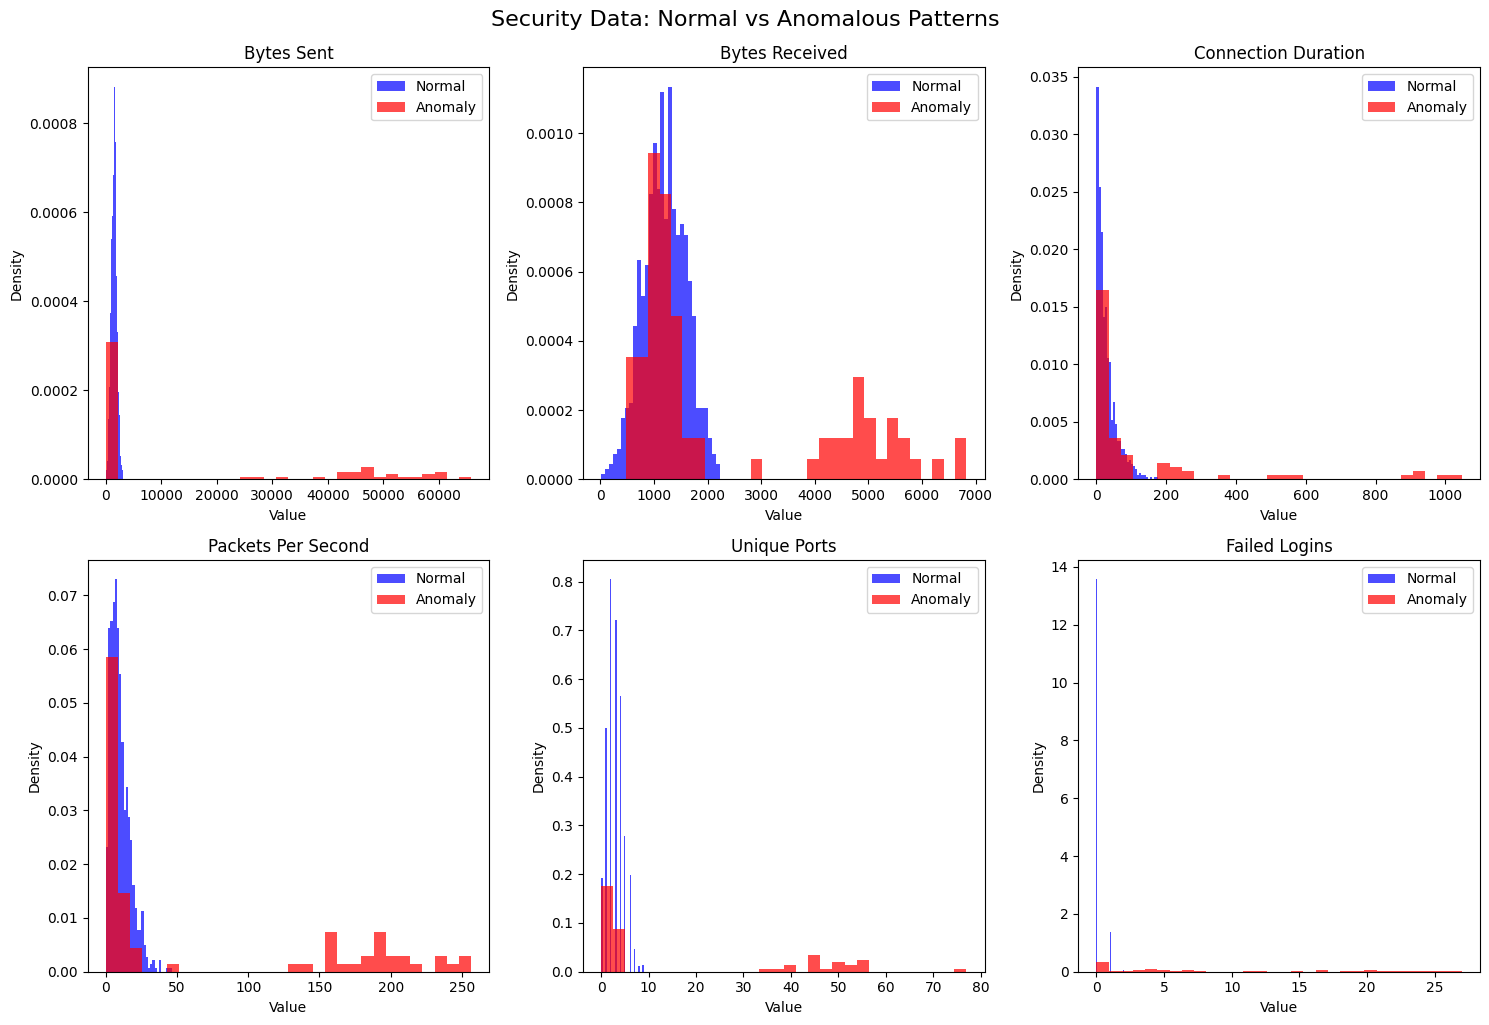

In [8]:
# Visualize the data distribution
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

features = ['bytes_sent', 'bytes_received', 'connection_duration', 'packets_per_second', 'unique_ports', 'failed_logins']

for i, feature in enumerate(features):
    # Plot normal vs anomalous distributions
    normal_data = security_data[security_data['is_anomaly'] == 0][feature]
    anomaly_data = security_data[security_data['is_anomaly'] == 1][feature]
    
    axes[i].hist(normal_data, bins=30, alpha=0.7, label='Normal', color='blue', density=True)
    axes[i].hist(anomaly_data, bins=30, alpha=0.7, label='Anomaly', color='red', density=True)
    axes[i].set_title(f'{feature.replace("_", " ").title()}')
    axes[i].legend()
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Density')

plt.tight_layout()
plt.suptitle('Security Data: Normal vs Anomalous Patterns', y=1.02, fontsize=16)
plt.show()

## 2. Traditional ML Approach: Anomaly Detection

Let's use proven ML techniques for anomaly detection and see how well they perform.

In [9]:
# Prepare features for ML models
feature_columns = ['bytes_sent', 'bytes_received', 'connection_duration', 'packets_per_second', 'unique_ports', 'failed_logins']
X = security_data[feature_columns]
y_true = security_data['is_anomaly']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Method 1: Isolation Forest
iso_forest = IsolationForest(contamination=0.08, random_state=42)
iso_predictions = iso_forest.fit_predict(X_scaled)
iso_predictions = (iso_predictions == -1).astype(int)  # Convert to 0/1

# Method 2: DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)
dbscan_predictions = (dbscan_labels == -1).astype(int)  # Noise points as anomalies

# Evaluate traditional ML approaches
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def evaluate_anomaly_detection(y_true, y_pred, method_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    
    print(f"\n🔍 {method_name} Results:")
    print(f"   Accuracy: {accuracy:.3f}")
    print(f"   Precision: {precision:.3f}")
    print(f"   Recall: {recall:.3f}")
    print(f"   F1-Score: {f1:.3f}")
    
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

# Evaluate both methods
iso_results = evaluate_anomaly_detection(y_true, iso_predictions, "Isolation Forest")
dbscan_results = evaluate_anomaly_detection(y_true, dbscan_predictions, "DBSCAN")

print(f"\n📊 Traditional ML Summary:")
print(f"   Both methods successfully identify anomalous patterns")
print(f"   They leverage statistical properties and data structure")
print(f"   Performance is measurable and interpretable")


🔍 Isolation Forest Results:
   Accuracy: 0.968
   Precision: 0.800
   Recall: 0.800
   F1-Score: 0.800

🔍 DBSCAN Results:
   Accuracy: 0.962
   Precision: 0.862
   Recall: 0.625
   F1-Score: 0.725

📊 Traditional ML Summary:
   Both methods successfully identify anomalous patterns
   They leverage statistical properties and data structure
   Performance is measurable and interpretable


## 3. LLM Approach: The Struggle with Numbers

Now let's see how an LLM handles the same anomaly detection task. We'll demonstrate the fundamental limitations.

In [13]:
# Function to test LLM on anomaly detection
def test_llm_anomaly_detection(sample_data, max_samples=10, frac=0.3):
    """
    Test LLM's ability to detect anomalies in numerical data
    """
    if not LLM_AVAILABLE:
        print("⚠️ OpenAI API not available. Showing conceptual example...")
        return demonstrate_llm_limitations()

    # Implement stratified sampling to ensure representation of both classes
    anomaly_samples = sample_data[sample_data['is_anomaly'] == 1]
    normal_samples = sample_data[sample_data['is_anomaly'] == 0]
    
    # Calculate how many samples to take from each group
    # Ensure at least one anomaly if available
    n_anomalies = min(max(1, int(max_samples * frac)), len(anomaly_samples))
    n_normal = min(max_samples - n_anomalies, len(normal_samples))
    
    # Sample from each group
    sampled_anomalies = anomaly_samples.sample(n=n_anomalies) if n_anomalies > 0 else pd.DataFrame()
    sampled_normal = normal_samples.sample(n=n_normal) if n_normal > 0 else pd.DataFrame()
    
    # Combine and shuffle to randomize order
    sample = pd.concat([sampled_normal, sampled_anomalies]).sample(frac=1).reset_index(drop=True)
    
    print(f"📊 Sampled {len(sample)} records ({n_anomalies} anomalies, {n_normal} normal)")
    
    # Take a small sample for LLM analysis
    #sample = sample_data.head(max_samples)
    
    # Create a prompt for the LLM
    prompt = f"""
You are a cybersecurity expert. Analyze the following network traffic data and identify which entries are anomalous (suspicious/malicious).

Data format: bytes_sent, bytes_received, connection_duration, packets_per_second, unique_ports, failed_logins

Data:
"""
    
    for idx, row in sample.iterrows():
        prompt += f"{idx+1}: {row['bytes_sent']:.1f}, {row['bytes_received']:.1f}, {row['connection_duration']:.1f}, {row['packets_per_second']:.1f}, {row['unique_ports']}, {row['failed_logins']}\n"
    
    prompt += """
Please respond with ONLY the index of the anomalous entries (e.g., "2, 5, 8"). If none are anomalous, respond with "None".
"""
    
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.1,
            max_tokens=100
        )
        
        llm_response = response.choices[0].message.content.strip()
        #print(f"🤖 LLM Response: {llm_response}")
        
        # Parse LLM response
        try:
            if llm_response.lower() == "none":
                llm_predictions = []
            else:
                llm_predictions = [int(x.strip()) - 1 for x in llm_response.split(',') if x.strip().isdigit()]
        except:
            llm_predictions = []
            print("⚠️ Could not parse LLM response")
        
        # Compare with ground truth
        actual_anomalies = sample[sample['is_anomaly'] == 1].index.tolist()
        
        print(f"\n📊 Comparison Results:")
        print(f"   Actual anomalies (indices): {actual_anomalies}")
        print(f"   LLM predicted anomalies: {llm_predictions}")
        
        # Calculate simple accuracy
        correct_predictions = len(set(llm_predictions) & set(actual_anomalies))
        total_anomalies = len(actual_anomalies)
        
        if total_anomalies > 0:
            recall = correct_predictions / total_anomalies
            print(f"   LLM Recall: {recall:.3f}")
        else:
            print(f"   No anomalies in sample to detect")
            
        return llm_predictions, actual_anomalies
        
    except Exception as e:
        print(f"❌ Error calling LLM: {e}")
        return demonstrate_llm_limitations()

def demonstrate_llm_limitations():
    """
    Demonstrate conceptual limitations when LLM API is not available
    """
    print("\n🎭 Conceptual LLM Limitations Demonstration:")
    print("\n1. 📊 Statistical Reasoning:")
    print("   - LLMs cannot calculate statistical measures (mean, std, percentiles)")
    print("   - They lack understanding of data distributions")
    print("   - Cannot identify outliers based on statistical significance")
    
    print("\n2. 🔢 Numerical Processing:")
    print("   - Poor at comparing numerical magnitudes accurately")
    print("   - Cannot perform mathematical operations reliably")
    print("   - Struggle with floating-point precision")
    
    print("\n3. 🧠 Pattern Recognition in Data:")
    print("   - Cannot learn from data patterns systematically")
    print("   - No memory of previous data points for comparison")
    print("   - Cannot adapt to new anomaly patterns")
    
    print("\n4. 📏 Scale and Context:")
    print("   - Cannot handle large datasets efficiently")
    print("   - Limited context window for data analysis")
    print("   - No understanding of domain-specific normal ranges")
    
    return [], []

# Test LLM on a sample of our data
print("🧪 Testing LLM Anomaly Detection Capabilities...\n")
llm_pred, actual_anom = test_llm_anomaly_detection(security_data, max_samples=10, frac=0.3)

🧪 Testing LLM Anomaly Detection Capabilities...

📊 Sampled 10 records (3 anomalies, 7 normal)

📊 Comparison Results:
   Actual anomalies (indices): [5, 6, 7]
   LLM predicted anomalies: [6]
   LLM Recall: 0.333


## 4. Blue Team Takeaways

As blue teamers, we need to understand when to use the right tool for the job. While Large Language Models (LLMs) excel at natural language tasks, they have significant limitations in:

1. **Anomaly Detection** - Identifying outliers in numerical data
2. **Predictive Analytics** - Making accurate predictions based on patterns
3. **Statistical Analysis** - Understanding data distributions and relationships

### ✅ When to Use Traditional ML:
- **Anomaly Detection**: Statistical outlier identification
- **Predictive Analytics**: Attack prediction, risk scoring
- **Pattern Recognition**: Behavioral analysis, clustering
- **Real-time Processing**: High-volume log analysis

### 🤖 When to Use LLMs:
- **Log Analysis**: Natural language log interpretation
- **Threat Intelligence**: Report summarization
- **Incident Response**: Playbook generation
- **Documentation**: Security procedure writing

### 🎯 Blue Team Best Practices:
1. **Hybrid Approach**: Use both technologies for their strengths
2. **Data Pipeline**: Traditional ML for detection, LLMs for explanation
3. **Validation**: Always validate LLM outputs with traditional methods
4. **Cost Consideration**: Traditional ML is more cost-effective for large-scale analysis

In [12]:
# Final comparison summary
print("🎯 BLUE TEAM DECISION MATRIX")
print("=" * 50)

comparison = {
    'Task': ['Anomaly Detection', 'Predictive Analytics', 'Pattern Recognition', 
             'Log Interpretation', 'Threat Intel Summary', 'Incident Documentation'],
    'Best Tool': ['Traditional ML', 'Traditional ML', 'Traditional ML', 
                  'LLM', 'LLM', 'LLM'],
    'Reason': ['Statistical precision', 'Numerical accuracy', 'Data structure analysis',
               'Natural language understanding', 'Text summarization', 'Content generation']
}

comparison_df = pd.DataFrame(comparison)
print(comparison_df.to_string(index=False))

🎯 BLUE TEAM DECISION MATRIX
                  Task      Best Tool                         Reason
     Anomaly Detection Traditional ML          Statistical precision
  Predictive Analytics Traditional ML             Numerical accuracy
   Pattern Recognition Traditional ML        Data structure analysis
    Log Interpretation            LLM Natural language understanding
  Threat Intel Summary            LLM             Text summarization
Incident Documentation            LLM             Content generation


# 5. Attendee Exercise

For the same sampled dataset, compare how ML and GenAI performed

In [15]:
def test_llm_anomaly_detection(sample_data, max_samples=10, frac=0.3):
    """
    Test LLM's ability to detect anomalies in numerical data using stratified sampling
    and compare with traditional ML approaches on the same sample
    """
    if not LLM_AVAILABLE:
        print("⚠️ OpenRouter API not available. Showing conceptual example...")
        return demonstrate_llm_limitations()
    
    # Implement stratified sampling to ensure representation of both classes
    anomaly_samples = sample_data[sample_data['is_anomaly'] == 1]
    normal_samples = sample_data[sample_data['is_anomaly'] == 0]
    
    # Calculate how many samples to take from each group
    # Ensure at least one anomaly if available
    n_anomalies = min(max(1, int(max_samples * 0.3)), len(anomaly_samples))
    n_normal = min(max_samples - n_anomalies, len(normal_samples))
    
    # Sample from each group
    sampled_anomalies = anomaly_samples.sample(n=n_anomalies) if n_anomalies > 0 else pd.DataFrame()
    sampled_normal = normal_samples.sample(n=n_normal) if n_normal > 0 else pd.DataFrame()
    
    # Combine and shuffle to randomize order
    sample = pd.concat([sampled_normal, sampled_anomalies]).sample(frac=1).reset_index(drop=True)
    
    print(f"📊 Sampled {len(sample)} records ({n_anomalies} anomalies, {n_normal} normal)")
    
    # Store actual anomaly labels for comparison
    actual_anomalies = sample[sample['is_anomaly'] == 1].index.tolist()
    print(f"🎯 Actual anomalies in sample: {[i+1 for i in actual_anomalies]}")
    
    # Get LLM predictions
    llm_predictions = get_llm_predictions(sample)
    
    # Run traditional ML on the same sample
    print("\n📈 Running traditional ML on the same sample...")
    
    # Isolation Forest
    iso_forest = IsolationForest(contamination=float(n_anomalies)/len(sample), random_state=42)
    features = sample.drop('is_anomaly', axis=1)
    iso_forest.fit(features)
    iso_preds = iso_forest.predict(features)
    iso_anomalies = [i for i, pred in enumerate(iso_preds) if pred == -1]
    print(f"🌲 Isolation Forest detected anomalies: {[i+1 for i in iso_anomalies]}")
    
    # DBSCAN
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    dbscan = DBSCAN(eps=1.0, min_samples=2)
    dbscan.fit(scaled_features)
    dbscan_anomalies = [i for i, label in enumerate(dbscan.labels_) if label == -1]
    print(f"🔍 DBSCAN detected anomalies: {[i+1 for i in dbscan_anomalies]}")
    
    # Calculate accuracy metrics
    llm_correct = len(set(llm_predictions).intersection(set(actual_anomalies)))
    iso_correct = len(set(iso_anomalies).intersection(set(actual_anomalies)))
    dbscan_correct = len(set(dbscan_anomalies).intersection(set(actual_anomalies)))
    
    # Calculate precision, recall, F1 score
    llm_precision = llm_correct / len(llm_predictions) if llm_predictions else 0
    iso_precision = iso_correct / len(iso_anomalies) if iso_anomalies else 0
    dbscan_precision = dbscan_correct / len(dbscan_anomalies) if dbscan_anomalies else 0
    
    llm_recall = llm_correct / len(actual_anomalies) if actual_anomalies else 0
    iso_recall = iso_correct / len(actual_anomalies) if actual_anomalies else 0
    dbscan_recall = dbscan_correct / len(actual_anomalies) if actual_anomalies else 0
    
    llm_f1 = 2 * (llm_precision * llm_recall) / (llm_precision + llm_recall) if (llm_precision + llm_recall) > 0 else 0
    iso_f1 = 2 * (iso_precision * iso_recall) / (iso_precision + iso_recall) if (iso_precision + iso_recall) > 0 else 0
    dbscan_f1 = 2 * (dbscan_precision * dbscan_recall) / (dbscan_precision + dbscan_recall) if (dbscan_precision + dbscan_recall) > 0 else 0
    
    # Print comparison table
    print("\n🔍 PERFORMANCE COMPARISON")
    print("=" * 50)
    comparison = {
        'Method': ['LLM', 'Isolation Forest', 'DBSCAN'],
        'Precision': [f"{llm_precision:.2f}", f"{iso_precision:.2f}", f"{dbscan_precision:.2f}"],
        'Recall': [f"{llm_recall:.2f}", f"{iso_recall:.2f}", f"{dbscan_recall:.2f}"],
        'F1 Score': [f"{llm_f1:.2f}", f"{iso_f1:.2f}", f"{dbscan_f1:.2f}"]
    }
    
    comparison_df = pd.DataFrame(comparison)
    print(comparison_df.to_string(index=False))
    
    return llm_predictions, actual_anomalies

def get_llm_predictions(sample):
    """
    Get anomaly predictions from LLM
    """
    # Create a prompt for the LLM
    prompt = """
You are a cybersecurity analyst examining network traffic data. 
Identify which of the following entries are anomalous based on their statistical properties.
Each row contains: bytes_sent, bytes_received, connection_duration, packets_per_second, unique_ports, failed_logins

Data:
"""
    
    for idx, row in sample.iterrows():
        prompt += f"{idx+1}: {row['bytes_sent']:.1f}, {row['bytes_received']:.1f}, {row['connection_duration']:.1f}, {row['packets_per_second']:.1f}, {row['unique_ports']}, {row['failed_logins']}\n"
    
    prompt += """
Please respond with ONLY the numbers of the anomalous entries (e.g., "2, 5, 8"). If none are anomalous, respond with "None".
"""
    
    try:
        response = client.chat.completions.create(
            model="openai/gpt-3.5-turbo",  # OpenRouter format
            messages=[{"role": "user", "content": prompt}],
            temperature=0.1,
            max_tokens=100
        )
        
        llm_response = response.choices[0].message.content.strip()
        print(f"🤖 LLM Response: {llm_response}")
        
        # Parse LLM response
        try:
            if llm_response.lower() == "none":
                llm_predictions = []
            else:
                llm_predictions = [int(x.strip()) - 1 for x in llm_response.split(',') if x.strip().isdigit()]
        except:
            llm_predictions = []
            print("⚠️ Could not parse LLM response")
        
        return llm_predictions
    
    except Exception as e:
        print(f"⚠️ Error calling LLM API: {e}")
        return []

In [17]:
# Call the function with your data
print("🧪 Testing LLM and Traditional ML Anomaly Detection Capabilities...\n")
llm_pred, actual_anom = test_llm_anomaly_detection(security_data, max_samples=10, frac=0.3)

🧪 Testing LLM and Traditional ML Anomaly Detection Capabilities...

📊 Sampled 10 records (3 anomalies, 7 normal)
🎯 Actual anomalies in sample: [3, 7, 10]
🤖 LLM Response: 7

📈 Running traditional ML on the same sample...
🌲 Isolation Forest detected anomalies: [2, 3, 7]
🔍 DBSCAN detected anomalies: [7]

🔍 PERFORMANCE COMPARISON
          Method Precision Recall F1 Score
             LLM      1.00   0.33     0.50
Isolation Forest      0.67   0.67     0.67
          DBSCAN      1.00   0.33     0.50
